In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Импортируем спаршенные данные
df = pd.read_excel(r"aktsii.xlsx")
df

,TICKER,ЦЕНА,КОЛИЧЕСТВО АКЦИЙ,ПРИБЫЛЬ,ВЫРУЧКА,FCF,Собственный капитал (EQUITY),АКТИВЫ 2021,АКТИВЫ 2022,ROA,ROS,Балансовая стоимость,Чистые активы,CEO's gender,CEO's age,CEO's nationality,CEO's education
0,ZILL,3150.0000,2659962,3388678000,3410539000,1853771000,34905075000,38744420000,44526809000,0.081389,0.993590,34905075000,34905075000,1,80,1,6
1,ASTR,495.9000,210000000,3074043000,5394988000,1638292000,1462802000,2146685000,6099931000,0.745528,0.569796,1462802000,1462802000,1,73,1,10
2,NKSH,78.0500,63731171,5047349000,9706967000,-11146000,3397267000,3963881000,8770669000,0.792702,0.519972,3397267000,3397267000,0,74,1,10
3,AQUA,852.5000,87876649,11927393000,23500965000,-630466000,27274467000,28887182000,42415376000,0.334557,0.507528,27274467000,27274467000,1,75,1,6
4,MOEX,200.4000,2276401458,36300000000,79692400000,1209083000000,176741800000,6143438300000,6619280300000,0.005688,0.455501,176741800000,176741800000,0,50,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,ELFV,0.6532,35371898370,-20218327000,50481443000,-1615022000,24831249000,91520317000,65354880000,-0.257763,-0.400510,24831249000,24831249000,1,53,1,10
93,SLEN,4.9600,1237175444,-6295000000,12475000000,-3245000000,11461000000,38654000000,28941000000,-0.186256,-0.504609,11461000000,11461000000,0,59,1,6
94,LIFE,5.1950,301010754,-207494000,379670000,-6823000,121099000,1425453000,1337921000,-0.150174,-0.546511,121099000,121099000,1,53,0,8
95,ARSA,12.0000,123817165,-82300000,38083000,-12606000,192942000,291739000,205474000,-0.331045,-2.161069,192942000,192942000,1,51,0,8


В работе нам необходимо проверить, оказывает ли влияние на выручку, прибыль и FCF компании пол, возраст и уровень образования генерального директора. Прежде, чем строить модель, попробуем оценить с помощью гистограмм, как распределяются финансовые показатели фирмы в зависимости от характеристик CEO

###Анализ влияния пола директора на финансовые показатели

In [4]:
#Посмотрим на средние и медианные значения финансовых показателей по рынку. Как видим, средние и медианные значения
# ROS и ROA у мужчин выше, чем у женщин. Однако нельзя сказать, что разница очень значительна.

df_for_analyze = df[["CEO's gender", "ROA", "ROS"]].replace([0,1], ["Female", "Male"])
df_for_analyze_mean = df_for_analyze.groupby(["CEO's gender"]).mean()
df_for_analyze_mean.round(2)
df_for_analyze_mean["ТИП"] = "Mean"

df_for_analyze_median = df_for_analyze.groupby(["CEO's gender"]).median()
df_for_analyze_median.round(2)
df_for_analyze_median["ТИП"] = "Median"

pd.concat([df_for_analyze_mean, df_for_analyze_median])

,ROA,ROS,ТИП
CEO's gender,,,
Female,0.067437,-0.025715,Mean
Male,0.086449,0.083025,Mean
Female,0.038832,0.048010,Median
Male,0.064286,0.087724,Median


<Axes: xlabel='ROS', ylabel='Count'>

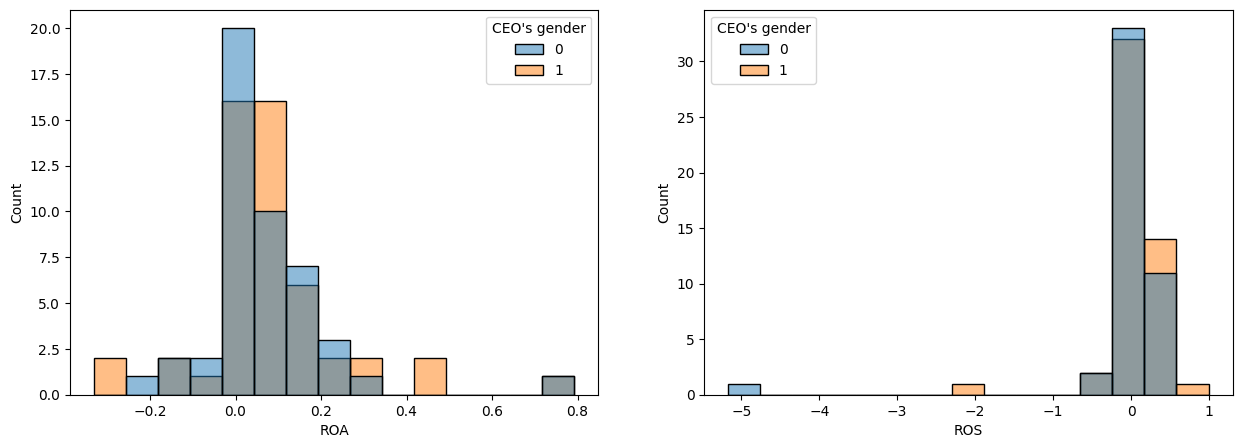

In [5]:
#Построим гистограмму распределния ROS и ROA в разрезе пола, чтобы проверить, действительно ли прослеживается связь.
#0 - CEO женщина, 1 - мужчина. Как видим из гистограммы, большинство значений сконцентрировались ближе к середине.
#к области медианных и средних значений за исключением отдельных выбросов. В абсолютном выражении все компании
#сконцентрировались в области от -0.2 до 0.2 для ROA и -0.5 до 0.5 для ROS. Явного полового перекоса в выбросах выше
#выше или ниже средних и медианных значений для общей выборки по рынку не наблюдается.

f, axes = plt.subplots(1, 2, figsize=(15, 5))


sns.histplot(df, x = "ROA", bins=15, hue= """CEO's gender""", ax=axes[0])
sns.histplot(df, x = "ROS", bins=15, hue= """CEO's gender""",  ax=axes[1])

<Axes: >

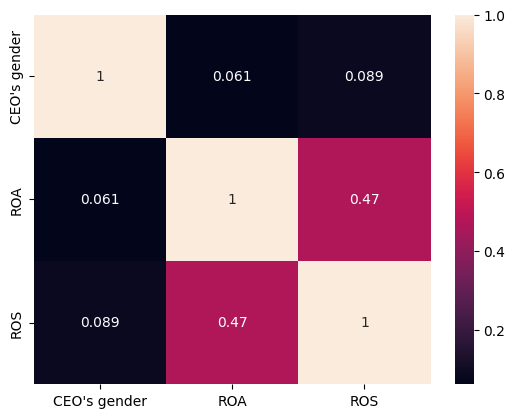

In [6]:
#Проведём последний тест корреляции между половым распределением и ROA/ROS. Как видим, корреляция фактически отсутствует.
#Мы не будем включать переменную пола в итоговое уравнение регрессии.

corr = df[["CEO's gender", "ROA", "ROS"]]
sns.heatmap(corr.corr(), annot=True)

###Анализ влияния национальности директора на финансовые показатели

In [7]:
#Посмотрим на средние и медианные значения финансовых показателей по рынку. Как видим, средние и медианные значения
# ROS и ROA у CEO-россиян выше, чем у иностранцев. При этом разница в средних и медианных значениях отличается почти в несколько раз
#друг от друга. Вероятно, будущие тесты подтвердят эту зависимость.

df_for_analyze = df[["CEO's nationality", "ROA", "ROS"]].replace([0,1], ["Иностранец", "Русский"])
df_for_analyze_mean = df_for_analyze.groupby(["CEO's nationality"]).mean()
df_for_analyze_mean.round(2)
df_for_analyze_mean["ТИП"] = "Mean"

df_for_analyze_median = df_for_analyze.groupby(["CEO's nationality"]).median()
df_for_analyze_median.round(2)
df_for_analyze_median["ТИП"] = "Median"

pd.concat([df_for_analyze_mean, df_for_analyze_median])

,ROA,ROS,ТИП
CEO's nationality,,,
Иностранец,-0.020663,-0.202060,Mean
Русский,0.092388,0.066303,Mean
Иностранец,0.021442,0.011876,Median
Русский,0.059713,0.087724,Median


<Axes: xlabel='ROS', ylabel='Count'>

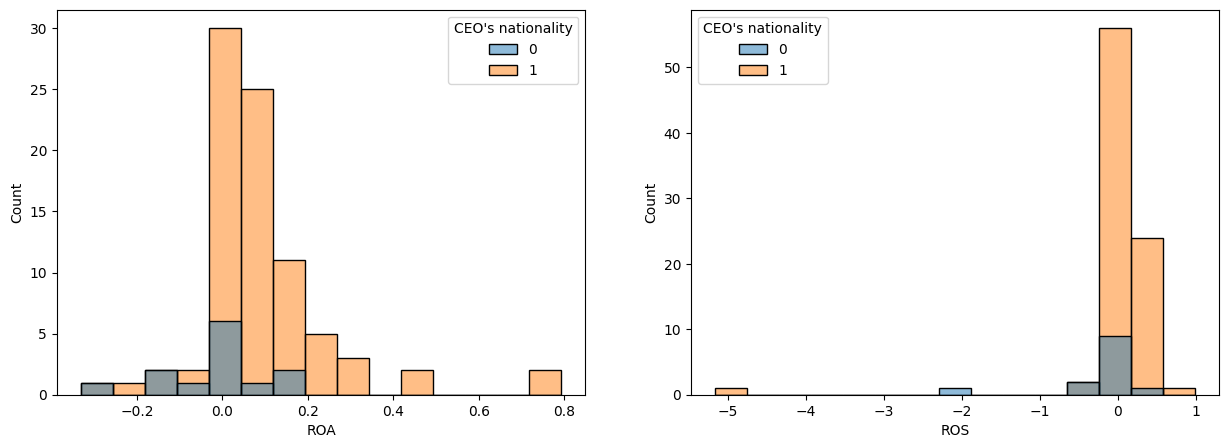

In [8]:
#Построим гистограмму распределния ROS и ROA в разрезе национальности, чтобы проверить, действительно ли прослеживается связь.
#0 - CEO россиянин, 1 - иностранец. Как видим из гистограммы, практически во всех группах ROA и ROS больше CEO-россиян.
#Это объясняется довольно просто - как правило генеральные директора в российских компаниях - это россияне, поэтому
#едва ли гистограмма поможет нам в проверке гипотезы о значимости переменной национальности. Тем не менее,
#даже в такой ситуации видно, что те компании, где генеральные директора иностранцы чаще превалируют в группах с ROS и ROA ниже
#среднего по рынку.


f, axes = plt.subplots(1, 2, figsize=(15, 5))


sns.histplot(df, x = "ROA", bins=15, hue= """CEO's nationality""", ax=axes[0])
sns.histplot(df, x = "ROS", bins=15, hue= """CEO's nationality""",  ax=axes[1])

<Axes: >

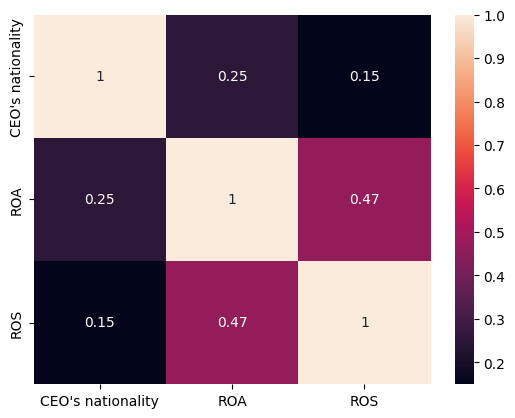

In [9]:
#Проведём последний тест корреляции между национальностью и ROA/ROS. Как видим, корреляция есть, хоть и слабая.
#На контрасте со значениями корреляции по полу эту переменную следует включить в уравнение регрессии и проверить её значимость
#На других тестах уже при работе с самим уравнением в будущем.

corr = df[["CEO's nationality", "ROA", "ROS"]]
sns.heatmap(corr.corr(), annot=True)

###Проверка влияния возраста директора на финансовые показатели

In [10]:
#Чтобы проверить зависимость между возрастом, ROA и ROS, построим диаграмму рассеивания. Но прежде, чем сделать это,
#нам необходимо очистить данные от выбросов. Сделаем это с помощью метода квартилей.

#Формируем минидатафрейсы возраста, которые проанализируем
AgeROA = df[["CEO's age", "ROA"]]
AgeROS = df[["CEO's age", "ROS"]]

#Очищаем датафрейм ROA от выбросов ROA
Q1 = df['ROA'].quantile(0.25)
Q3 = df['ROA'].quantile(0.75)
IQR = Q3-Q1
AgeROA = AgeROA[(AgeROA['ROA'] < Q1-1.5*IQR ) | (AgeROA['ROA'] > Q3+1.5*IQR)]

#Очищаем датафрейм ROA от выбросов ROS
Q1 = df['ROS'].quantile(0.25)
Q3 = df['ROS'].quantile(0.75)
IQR = Q3-Q1
AgeROS = AgeROS[(AgeROS['ROS'] < Q1-1.5*IQR ) | (AgeROS['ROS'] > Q3+1.5*IQR)]

<Axes: >

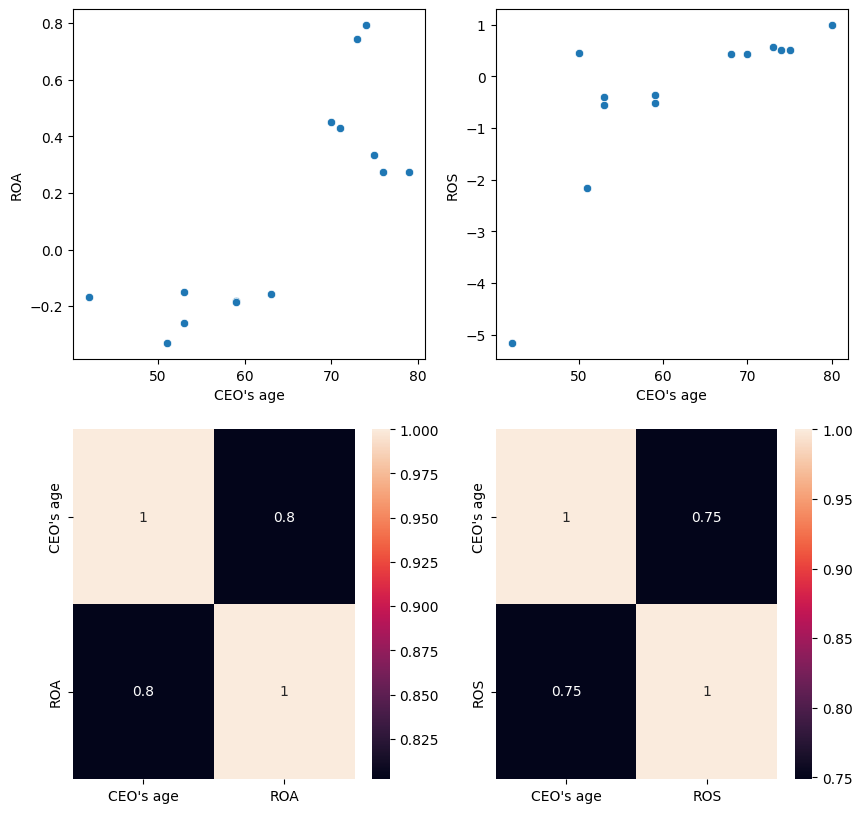

In [11]:
#Теперь построим диаграммы рассеивания на основе полученных данных. Как видим, наблюдается довольно очевидная прямая зависимость
#Чем выше возраст директора, тем лучшие финансовые показатели у фирмы. Подтвердим нашу гипотезу также корреляционным анализом.
#Что и требовалось ожидать - связь между показателями возраста директора и финансовыми результатами очень сильная.


f, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.scatterplot(AgeROA, x = "CEO's age", y = "ROA", ax=axes[0,0])
sns.scatterplot(AgeROS, x = "CEO's age", y = "ROS",ax=axes[0,1])

sns.heatmap(AgeROA.corr(), annot=True, ax=axes[1,0])
sns.heatmap(AgeROS.corr(), annot=True, ax=axes[1,1])




###Проверка влияния уровня образования директора на финансовые результаты компании

In [12]:
#Чтобы проверить зависимость между образованием в года, ROA и ROS, построим диаграмму рассеивания. Но прежде, чем сделать это,
#нам необходимо очистить данные от выбросов. Сделаем это с помощью метода квартилей.

#Формируем минидатафрейсы образования, которые проанализируем
EduROA = df[["CEO's education", "ROA"]]
EduROS = df[["CEO's education", "ROS"]]

#Очищаем датафрейм ROA от выбросов ROA
Q1 = df['ROA'].quantile(0.25)
Q3 = df['ROA'].quantile(0.75)
IQR = Q3-Q1
EduROA = EduROA[(EduROA['ROA'] < Q1-1.5*IQR ) | (EduROA['ROA'] > Q3+1.5*IQR)]

#Очищаем датафрейм ROA от выбросов ROS
Q1 = df['ROS'].quantile(0.25)
Q3 = df['ROS'].quantile(0.75)
IQR = Q3-Q1
EduROS = EduROS[(EduROS['ROS'] < Q1-1.5*IQR ) | (EduROS['ROS'] > Q3+1.5*IQR)]

<Axes: >

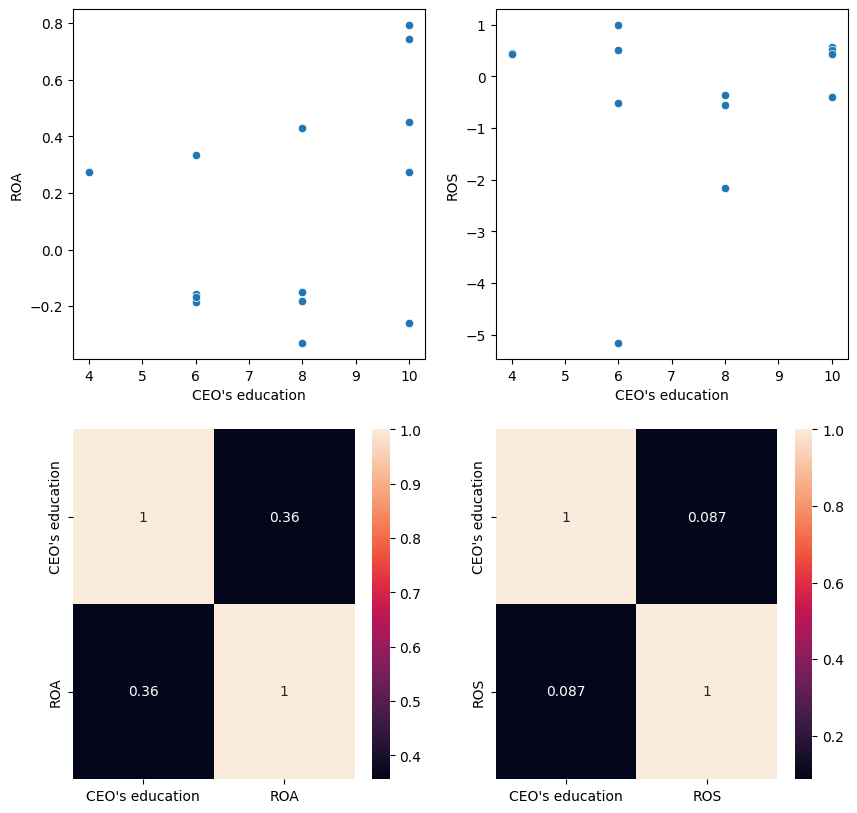

In [13]:
#Построим диаграммы рассеивания и корреляционные матрицы уровня образования. Обе диаграммы показали довольно хаотичную связь:
#нельзя точно увидеть какой-то тренд между уровнем образования и финансовыми показателями. При этом корреляционный анализ
#Тоже дал неоднозначные результаты - между уровнем образования и ROA наблюдается слабая связь со стремлением к средней.
#В то же время между ROS и уровнем образования связь не наблюдается вообще. Возможно, связь между ROA и уровнем образования
#можно объяснить тем, что директоров с несколькими высшими (8 - 10 лет обучения) чаще берут на работу именно крупные компании
#и назначают на высокие должности. Но при этом не факт, что такие директора будут генерировать прибыль, что объясняет
#отсутствие связи между образованием и ROS. Не будем включать эту переменную в уравнение регрессии.

f, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.scatterplot(EduROA, x = "CEO's education", y = "ROA", ax=axes[0,0])
sns.scatterplot(EduROS, x = "CEO's education", y = "ROS",ax=axes[0,1])

sns.heatmap(EduROA.corr(), annot=True, ax=axes[1,0])
sns.heatmap(EduROS.corr(), annot=True, ax=axes[1,1])




В результате анализа переменных мы обнаружили две потенциально влияющие переменные - возраст и национальность генерального директора. При этом в статистике остались еще переменные, которые могут повлиять на финансовые результаты компании.
Построим корреляционные матрицы по оставшимся данным и отберем те, где будет наблюдаться хотя бы минимальная связь между влияющими и зависимыми переменными.

<Axes: >

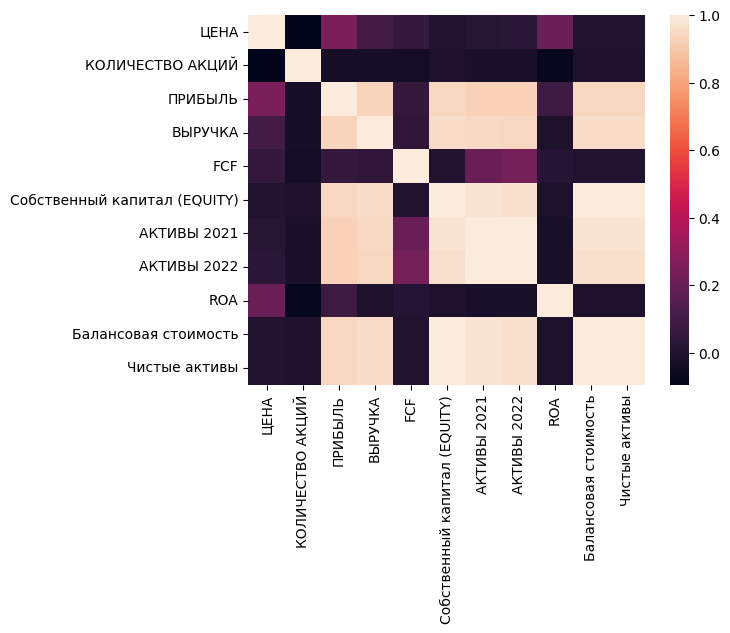

In [14]:
#В данном случае целевая переменная - это ROA. Хотя бы минимальная связь наблюдается между ROA и ценой и Прибылью. В остальных случаях
#Корреляция фактически отсутствует.

dfCorrelationROA = df.loc[:, ~df.columns.isin(['TICKER', "CEO's gender", "CEO's age", "CEO's nationality", "CEO's education","ROS"])]

sns.heatmap(dfCorrelationROA.corr())

<Axes: >

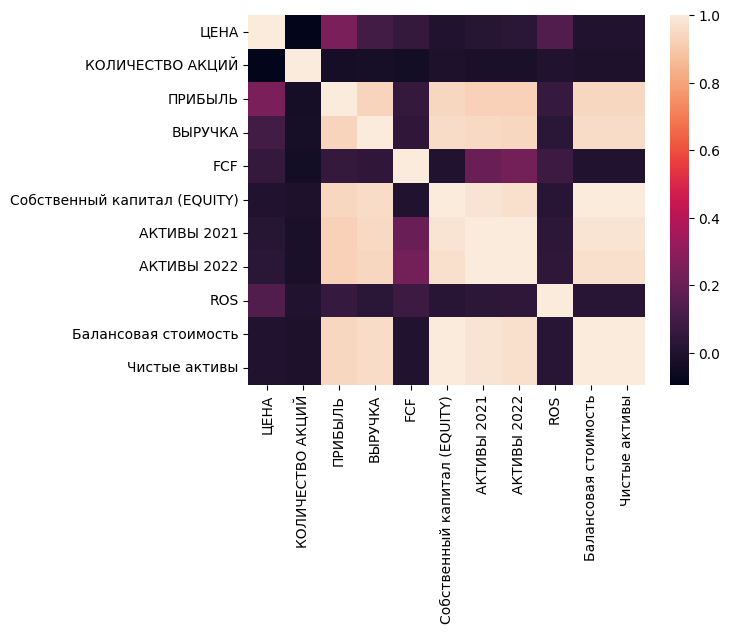

In [15]:
#В данном случае целевая переменная - это ROS. Хотя бы минимальная связь наблюдается между ROA и ценой и Прибылью и FCF. В остальных случаях
#Корреляция фактически отсутствует.

dfCorrelationROS = df.loc[:, ~df.columns.isin(['TICKER', "CEO's gender", "CEO's age", "CEO's nationality", "CEO's education","ROA"])]

sns.heatmap(dfCorrelationROS.corr())

Итого мы получили уравнения регрессии для прогнозирования ROA и ROS:

ROA = a0 + ЦЕНА + ПРИБЫЛЬ + CEO's age + CEO's nationality + error

ROS = a0 + ЦЕНА + ПРИБЫЛЬ + FCF + CEO's age + CEO's nationality + error

In [16]:
#Переёдйм к построению моделей. Для этого импортируем эконометрические библиотеки

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

###Построение и анализ модели ROA

In [36]:
#Модель ROA

y = df["ROA"]
x = df[["ЦЕНА", "ПРИБЫЛЬ", "CEO's age", "CEO's nationality"]]
x = sm.add_constant(x)

results = sm.OLS(y, x).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     10.58
Date:                Tue, 02 Jan 2024   Prob (F-statistic):           4.28e-07
Time:                        16:09:26   Log-Likelihood:                 61.716
No. Observations:                  97   AIC:                            -113.4
Df Residuals:                      92   BIC:                            -100.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.4388      0.085     -5.192      0.000      -0.607      -0.271
ЦЕНА               7.494e-06   5.88e-06      1.275      0.205   -4.18e-06    1.92e-05
ПРИБЫЛЬ            5.024e-14   9.72e-14      0.517      0.606   -1.43e-13    2.43e-13
CEO's age             0.0070      0.001      5.367      0.000       0.004       0.010
CEO's nationality     0.0742      0.040      1.861      0.066      -0.005       0.153
==============================================================================
Omnibus:                       66.339   Durbin-Watson:                   1.234
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              420.041
Skew:                           2.124   Prob(JB):                     6.16e-92
Kurtosis:                      12.267   Cond. No.                     9.28e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.28e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Прежде, чем перейти к анализу модели на точность, нам следует проверить, не допустили ли мы стандартные ошибки при построении регрессии, а именно:

- Включение в модель незначимых переменных
- Неправильно подобранная функция регрессии
- Невключение важных регрессоров модель

Кроме того, эконометристы часто проверяют данные на ошибку четвертого рода, а именно на автокорреляцию остатков с помощью теста Чоу. В нашем случае это делать нецелесообразно, так как данные пространственные и не являются временными рядами.

In [37]:
#Проверка на ошибку первого рода - незначимые переменные.
#Для проверки нам необходимо сравнить коэффицент t регрессора (отношение коэффициента к std err) к t критическому при 
#alfa = 0.05 и степенях свободы n-k = 97 - 5 = 92

t_crit = scipy.stats.t.ppf(1-0.05/2, 92)
t_crit

#t критическое равно 1.986. Переменные ЦЕНА и ПРИБЫЛЬ имеют t ниже t критического. Исключим эти переменные из модели как незначимые
#И повторим тест



1.9860863168388934

In [38]:
#Модель ROA

y = df["ROA"]
x = df[["CEO's age", "CEO's nationality"]]
x = sm.add_constant(x)

results = sm.OLS(y, x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     19.89
Date:                Tue, 02 Jan 2024   Prob (F-statistic):           6.26e-08
Time:                        16:11:42   Log-Likelihood:                 60.481
No. Observations:                  97   AIC:                            -115.0
Df Residuals:                      94   BIC:                            -107.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.4471      0.084     -5.302      0.000      -0.615      -0.280
CEO's age             0.0073      0.001      5.612      0.000       0.005       0.010
CEO's nationality     0.0760      0.040      1.907      0.060      -0.003       0.155
==============================================================================
Omnibus:                       60.580   Durbin-Watson:                   1.181
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              337.971
Skew:                           1.940   Prob(JB):                     4.08e-74
Kurtosis:                      11.280   Cond. No.                         406.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""